# Practical Session - Genome Assembly
# Part 2

In this practical session you will:
- Construct a De Bruijn graph from read-pairs
- Find Contigs in a De Bruijn graph
- Assemble a real viral genome

#### How exciting! Let's start!
>Students names: Lev Gourevitch

The following functions are implemented functions from the previous practical session, you can use them.

In [4]:
def create_graph(nodes, edges):
    graph = nx.MultiDiGraph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    
    return graph

In [5]:
def composition(text, k):
    kmers = []
    for i in range(len(text) - k + 1):
        kmers.append(text[i:i+k])
    return kmers

In [6]:
import networkx as nx

def debruijn(kmers):
    graph = nx.MultiDiGraph()

    for kmer in kmers:
        kmer_perfix = kmer[:-1]
        kmer_suffix = kmer[1:]

        graph.add_edge(kmer_perfix, kmer_suffix)
    
    return graph

In [7]:
from IPython.display import Image

def draw_graph(g):
    d = nx.drawing.nx_pydot.to_pydot(g)

    png_str = d.create_png()
    img = Image(data=png_str)
    display(img)

In [8]:
def eulerize(graph):
    """
    Adds an edge between two nodes in order to create an euler cycle
    
    Args:
        graph: a graph with an Euler path

    Returns:
        The starting node of an eulerian path
    """
    
    left_node = -1
    right_node = -1
    for node in graph.nodes:
        if graph.out_degree(node) > graph.in_degree(node):
            right_node = node
        elif graph.out_degree(node) < graph.in_degree(node):
            left_node = node
            
    if left_node != -1 and right_node != -1:
        graph.add_edge(left_node, right_node)
        
    return right_node

In [9]:
def path_to_genome(kmers):
    """Concatanates a list of kmers to a string"""
    text = kmers[0]
    for kmer in kmers[1:]:
        text += kmer[-1]
        
    return text       

In [10]:
def get_euler_cycle_nodes(graph, src_node):
    """
    Finds an euler path in a graph
    
    Args:
        graph: a graph with an Euler path

    Returns:
        The nodes of an eulerian path
    """
    cycle = nx.eulerian_circuit(graph, source=src_node)
    cycle_nodes = [e[0] for e in cycle]
    
    return cycle_nodes

In [11]:
def get_euler_path(graph):
    """Returns an euler path """
    src_node = eulerize(graph)
    nodes = get_euler_cycle_nodes(graph, src_node)

    return nodes

## 1. Debruijn of read-pairs

Build a De Bruijn graph from read-pairs, and construct the genome

- Input: A list of read-pairs of k-mers, with distance $d$ between each pair of k-mers
- Output: A reconstructed genome

**Sample Input:**   
$k=4$  
$d=2$  
('GAGA', 'TTGA')  
('TCGT', 'GATG')  
('CGTG', 'ATGT')  
('TGGT', 'TGAG')  
('GTGA', 'TGTT')  
('GTGG', 'GTGA')  
('TGAG', 'GTTG')  
('GGTC', 'GAGA')
('GTCG', 'AGAT')

**Sample Output:**   
GTGGTCGTGAGATGTTGA

In [12]:
from typing import List, Tuple

def debruijn_from_read_pairs(read_pairs: List[Tuple[str, str]]):
    
    graph = nx.MultiDiGraph()
    
    #write your code here
    for p_0, p_1 in read_pairs:
        graph.add_edge(f"{p_0[:-1]}\n{p_1[:-1]}", f"{p_0[1:]}\n{p_1[1:]}")

    return graph

Let's look at the graph:

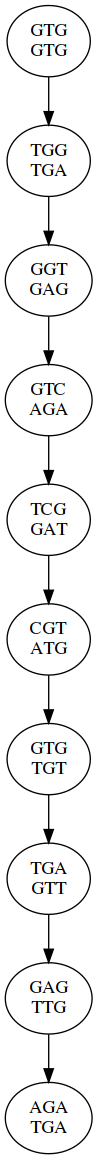

In [13]:
read_pairs = [('GAGA', 'TTGA'), ('TCGT', 'GATG'), ('CGTG', 'ATGT'), ('TGGT', 'TGAG'), ('GTGA', 'TGTT'), ('GTGG', 'GTGA'), 
              ('TGAG', 'GTTG'), ('GGTC', 'GAGA'), ('GTCG', 'AGAT')]
k = 4
d = 2

graph = debruijn_from_read_pairs(read_pairs)
draw_graph(graph)

In [14]:
from functools import reduce
def read_pairs_path_to_genome(kmer_pairs, k, d):
    """
    Reconstructs a genome from a path of read pairs
    
    Args:
        kmer_pairs: a list of read pairs that form a path in a debruijn graph

    Returns:
        A genome represented by the path if exists, else an empty string
    """
    
    #write your code here
    first_part = reduce(lambda acc, node: acc + node.split('\n')[0][-1],
                        kmer_pairs[1:],
                        kmer_pairs[0].split('\n')[0])
    second_part = reduce(lambda acc, node: acc + node.split('\n')[1][-1],
                        kmer_pairs[1:],
                        kmer_pairs[0].split('\n')[1])
    
    genome = first_part[:k+d] + second_part
    return genome

Test your code:

In [15]:
read_pairs = [('GAGA', 'TTGA'), ('TCGT', 'GATG'), ('CGTG', 'ATGT'), ('TGGT', 'TGAG'), ('GTGA', 'TGTT'), ('GTGG', 'GTGA'), 
              ('TGAG', 'GTTG'), ('GGTC', 'GAGA'), ('GTCG', 'AGAT')]
k = 4
d = 2

graph = debruijn_from_read_pairs(read_pairs)
path = get_euler_path(graph)

assert 'GTGGTCGTGAGATGTTGA' == read_pairs_path_to_genome(path, k, d)

## 2. Non-branching paths

In this part of will find all non-branching paths in a De-Bruijn graph (that represent contigs)

A node $v$ in a directed graph Graph is called a **1-in-1-out node** if its indegree and outdegree are both equal to 1.   
A "maximal non-branching path" is a path whose internal nodes are 1-in-1-out nodes and whose initial and final nodes are not 1-in-1-out nodes.  
A special case of a "maximal non-branching path" is an **isolated cycle**: a cycle in which all nodes are 1-in-1-out nodes.

#### Solve the Maximal non-branching paths problem.
- Input: A graph
- Output: The collection of all maximal nonbranching paths in this graph

**Sample Input:**   
1 -> 1,2  
2 -> 3  
3 -> 4,4,5  
6 -> 7  
7 -> 6  

**Sample Output:**   
1 -> 2 -> 3  
1 -> 1  
3 -> 4  
3 -> 4  
3 -> 5  
7 -> 6 -> 7  

The following methods could be useful:  
`list(graph.neighbors(node))` returns a list of neighbors of a node   
`len(graph.get_edge_data(node1, node2))` returns the number of edges between two nodes  
See example below:

In [16]:
nodes = list(range(1, 8))
edges = [(1, 1), (1, 2), (2, 3), (3, 4), (3, 4), (3, 5), (6, 7), (7, 6)]

graph = create_graph(nodes, edges)

#get the neighbors of a node
print(list(graph.neighbors(3)))

#get the number of edges between two nodes
print(len(graph.get_edge_data(3, 4)))

[4, 5]
2


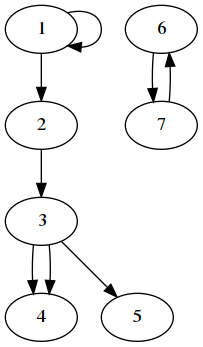

In [17]:
draw_graph(graph)

In [113]:
def iter_contig_start_nodes(graph: nx.MultiDiGraph):
    for n in graph:
        if graph.in_degree(n) != 1 or graph.out_degree(n) != 1:
            if graph.out_degree(n):
                yield n


def find_regular_paths(graph: nx.MultiDiGraph):
    paths = []
    
    #write your code here
    def valid_path_node(node): 
        return graph.in_degree(node) == 1 and graph.out_degree(node) == 1  
    
    for node in iter_contig_start_nodes(graph):
        for neighbour in graph.neighbors(node):
            cur_path = [node]
            cur_node = neighbour
            
            while valid_path_node(cur_node): 
                cur_path.append(cur_node)
                cur_node = next(graph.neighbors(cur_node))
                
            cur_path.append(cur_node)
            [paths.append(cur_path) for _ in range(graph.number_of_edges(cur_path[-2], cur_path[-1]))]
    
    return paths


def find_two_node_cycle_paths(graph: nx.MultiDiGraph):
    paths = []
    for cycle in nx.simple_cycles(graph):
        if len(cycle) > 1 and \
                all(graph.out_degree(n) == 1 and graph.in_degree(n) == 1 
                    for n in cycle):
            paths.append(cycle + [cycle[0]])    
    return paths


def max_non_branching_paths(graph: nx.MultiDiGraph):
    """
    Finds non branching paths in a graph, including isolated cycles
    
    Args:
        graph: a debruijn graph

    Returns:
        A list of paths, each path is a list
    """
    paths = []
    
    #write your code here
    paths.extend(find_regular_paths(graph))
    paths.extend(find_two_node_cycle_paths(graph))
    
    return paths



Test your code

In [114]:
nodes = list(range(1, 8))
edges = [(1, 1), (1, 2), (2, 3), (3, 4), (3, 4), (3, 5), (6, 7), (7, 6)]

graph = create_graph(nodes, edges)
paths = max_non_branching_paths(graph)

expected_paths = [[6, 7, 6],
[3, 5],
[1, 1],
[1, 2, 3],
[3, 4],
[3, 4]
]

paths_str = [' '.join([str(node) for node in path]) for path in paths]
expected_paths_str = [' '.join([str(node) for node in path]) for path in expected_paths]

print(paths_str, expected_paths_str)
assert sorted(expected_paths_str) == sorted(paths_str)

['1 1', '1 2 3', '3 4', '3 4', '3 5', '6 7 6'] ['6 7 6', '3 5', '1 1', '1 2 3', '3 4', '3 4']


## 3. Find Contigs

#### Contig Generation Problem: Generate the contigs from a collection of reads (with imperfect coverage).
- Input: A collection of k-mers $Patterns$. 
- Output: All contigs in $DeBruijn(Patterns)$.

**Sample Input:**   
ATG  
ATG   
TGT  
TGG  
CAT  
GGA  
GAT  
AGA  

**Sample Output:**   
AGA ATG ATG CAT GAT TGGA TGT

> **This problem was already solved for you. Solve the next problem - contigs from read pairs**

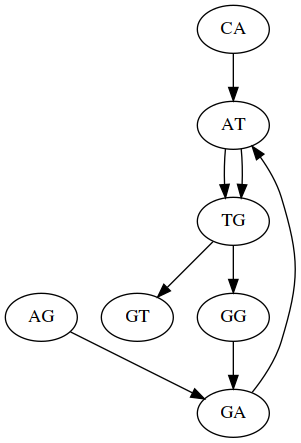

In [115]:
patterns = ['ATG',
'ATG',
'TGT',
'TGG',
'CAT',
'GGA',
'GAT',
'AGA']

def get_cotings(patterns):
    graph = debruijn(patterns)
    paths = max_non_branching_paths(graph)
    
    return [path_to_genome(path) for path in paths]

draw_graph(debruijn(patterns))

In [116]:
print(set(get_cotings(patterns)) )
assert set(get_cotings(patterns)) == set(['AGA', 'ATG', 'ATG', 'CAT', 'GAT', 'TGGA', 'TGT'])

{'ATG', 'CAT', 'TGGA', 'GAT', 'TGT', 'AGA'}


### Solve the Contig Generation Problem for read pairs.
- Input: A collection of read pairs $Patterns$. 
- Output: All contigs in $DeBruijn(Patterns)$.

**Sample Input:**   
$k=2$  
$d=1$  
('TC', 'GT')  
('CA', 'TT')  
('AG', 'TA')  
('GA', 'TG')  
('AC', 'GC')  
('CT', 'CA')

**Sample Output:**   
['TCAGTTA', 'GACTGCA']

In [117]:
def get_contigs_from_read_pairs(read_pairs, k, d):
    
    #write your code here
    graph = debruijn_from_read_pairs(read_pairs)
    paths = max_non_branching_paths(graph)
    
    contigs = [read_pairs_path_to_genome(p, k, d) for p in paths]
    
    return contigs


Test your code

In [118]:
k = 2
d = 1
read_pairs = [('TC', 'GT'),  
('CA', 'TT'),  
('AG', 'TA'),  
('GA', 'TG'),  
('AC', 'GC'),  
('CT', 'CA')]

expected_contigs = ['GACTGCA', 'TCAGTTA']

contigs = get_contigs_from_read_pairs(read_pairs, k, d)

assert sorted(contigs) == expected_contigs

## 4. Final Challenge

*Leuconostoc phage L5* is a small virus with a small genome (only 2435 bp).

Given a collection of simulated error-free read-pairs (with exact distance $d = 50$ between reads of length $k = 100$ within a read-pair), use the paired de Bruijn graph to reconstruct the *Leuconostoc phage L5* genome. 

Compare this assembly to the assembly obtained from the classic de Bruijn graph (i.e., when all we know is the reads themselves and do not know the distance between paired reads) in order to better appreciate the benefits of read-pairs. 

The read pairs are in the file *read_pairs.txt*

In [119]:
k = 10
d = 50

read_pairs = []
kmers = []

with open('read_pairs.txt') as f:
    for line in f:
        read_pairs.append(tuple(line.strip().split('|')))
    
with open('kmers.txt') as f:
    for line in f:
        kmers.append(line[:-1])
        

In [120]:
#create contigs from read pairs
get_contigs_from_read_pairs(read_pairs, k, d)


['ggccgctagtaatcgtgtaattcaaattgataaacgattattagacgtattaaagagatataagcgcgtttctggtttattggtacaagtaacaagagaagcgattaatcacgttctaacaaaagatttaaagcacatagaagcaaaaaacgttacctttcacgccttgcgccatagccatgcaagttatttatt',
 'tttaaagcacatagaagcaaaaaacgttacctttcacgccttgcgccatagccatgcaagttatttattatctaagggtgtttcaattcaatatgtaagcgagcgtttgggacattccaatgttggaattacagaaaatgtgtattctcatttattaaaaacgctcagggaaaacgaagaaaaaaagatcactgatttaatggattttcagtgatttttttgtgcgatttttgtgcgatgtgcgcaaatttgtgcgatttttttgcgtttatttgcttttgtttgcgttggtttgaacgggctgaaagccttggtacgactgcgtttaagcaaacaaaaagctctatatcaactttcgtcaatatagagcctaaatgccccaaacaggcacaaggtaagcctatattacagcgtttctagcctgttgttgtgcaattgttgtgcaaattatttgttgttttcaatttctttttttagccattttgtaattatcgaagatacactttcgttcttttcaattgctaaaattcttatctgtttgataacttcttcatctaatgtagttgtaaatttctttttcatataaataactatactcttttatagtgtattgacaatacacactaaagtgtatattgtatatttcagatacgaaagggaatatataaggcatgttaaaagaagttaaatatgaagatgcagtacacaacaaaatttttaatgatttcgtaagcaaaaggata',
 'tttaaagcataaaaaaagagcgtctaaccaattaaggccagacgctttta

In [122]:
#create contigs from regular reads
cs = get_cotings(kmers)
sorted(cs)


['ggccgctagtaatcgtgtaattcaaattgataaacgattattagacgtattaaagagatataagcgcgtttctggtttattggtacaagtaacaagagaagcgattaatcacgttctaacaaaagatttaaagca', 'tttaaagcacatagaagcaaaaa', 'tttaaagcataaaaaaaga', 'aagcaaaaaacgtta', 'aagcaaaaatccaataactat', 'aaaacgttacctttcacgccttgcgccatagccatgcaagttatttatt', 'aaaacgttaaaaaagtac', 'ttatttattatctaagggtgtttcaat', 'ttatttattt', 'ttatttattt', 'ttatttattt', 'tgtttcaattcaatat', 'tgtttcaatgctaaaaacacctatgaaactcccgattgatgctttgtttgc', 'attcaatatg', 'attcaatatg', 'ttcaatatgtaagcgagcgtttgggacattccaatgttggaattacagaaaatgtgtattctcatttattaaaaacgctcagggaaaacgaagaa', 'ttcaatatgctgctgaaaacggtacattaaagaaaaatcacaattgatatatataag', 'aacgaagaaaaaaaga', 'aacgaagaacacgatataactaatgctttaaaatcgcttacaatacaaagcgtcccaaaggactacattttaagcgtctttgttattgaagacaattgtaacgatag', 'aaaaaaagatcactgatttaatggattttcagtgattttttt', 'aaaaaaagagcgtctaaccaattaaggccagacgcttttaatttattta', 'gatttttttg', 'gatttttttg', 'atttttttgtgc', 'atttttttgcgtttatttgcttttgtttgc', 'tttttgtgcg', 'tttttgtgcg', 'ttttgtgcga', 'tttt